## **1. Import Necessary Libraries**

In [60]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from tabulate import tabulate
from matplotlib.colors import LinearSegmentedColormap

plt.style.use('ggplot') 

## **2. Load and Inspect Dataset**

In [4]:
# Load dataset
df = pd.read_csv('winequality-red.csv')

# Display basic information about the dataset
print("Dataset Shape:", df.shape)
print(df.head(), "\n")
print(df.info(),"\n")
print("Unique quality values:", df['quality'].unique())

Dataset Shape: (1599, 12)
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8      

## **3. Data Transformation and Distribution Analysis**

In [7]:
# Convert quality to binary (good: 6 or higher, bad: below 6)
df['newquality'] = df['quality'].apply(lambda x: 1 if x <= 5 else 2)

# Display distribution of new quality labels
print("New Quality Distribution:", sorted(Counter(df['newquality']).items()))

New Quality Distribution: [(1, 744), (2, 855)]


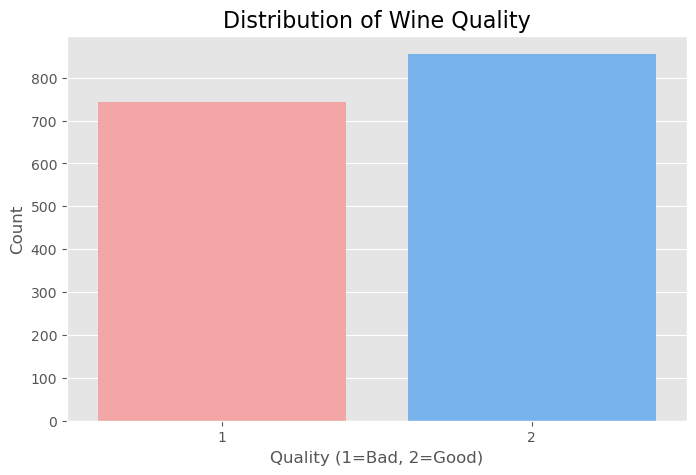

In [9]:
# Count plot for wine quality distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='newquality', data=df, hue='newquality', palette=['#ff9999', '#66b3ff'], legend=False)
plt.title('Distribution of Wine Quality', fontsize=16)
plt.xlabel('Quality (1=Bad, 2=Good)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## **4. Feature Analysis with Histograms**

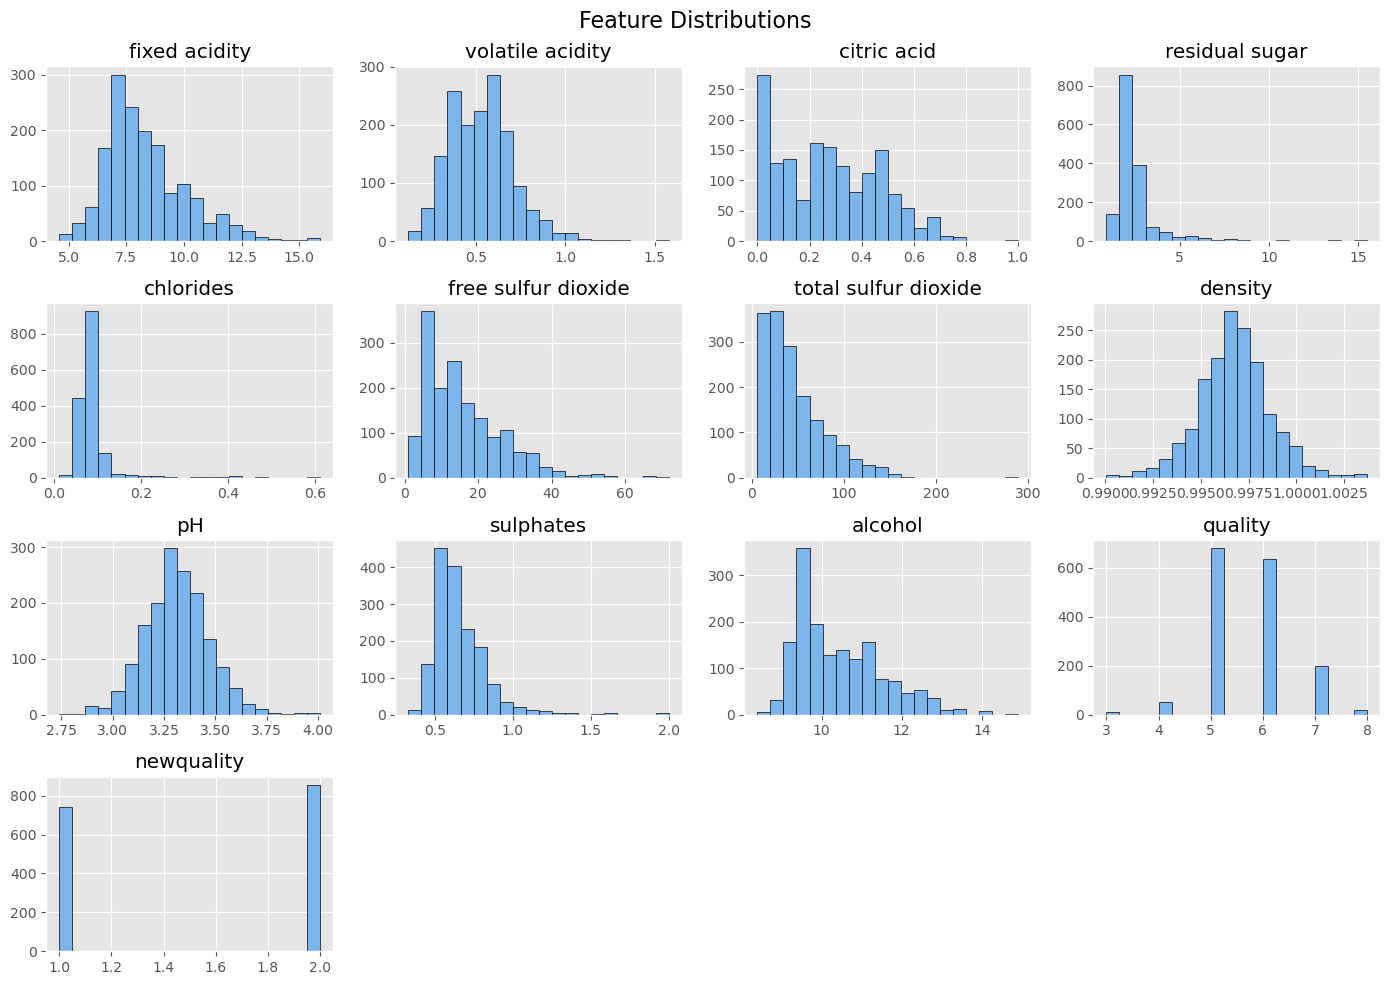

In [11]:
# Histograms of features
df.hist(bins=20, figsize=(14, 10), color='#7cb5ec', edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)
plt.tight_layout()
plt.show()

## **5. Bivariate Analysis**

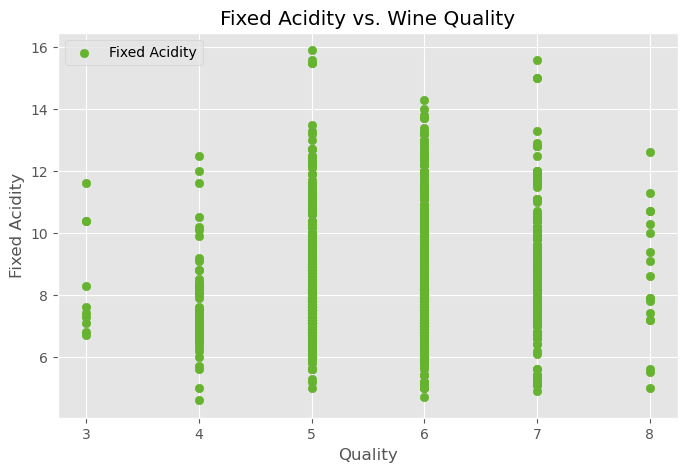

In [16]:
# Fixed acidity vs. quality
plt.figure(figsize=(8, 5))
plt.scatter(df['quality'], df['fixed acidity'], color='#66b32f', label='Fixed Acidity')
plt.title('Fixed Acidity vs. Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Fixed Acidity')
plt.legend()
plt.show()

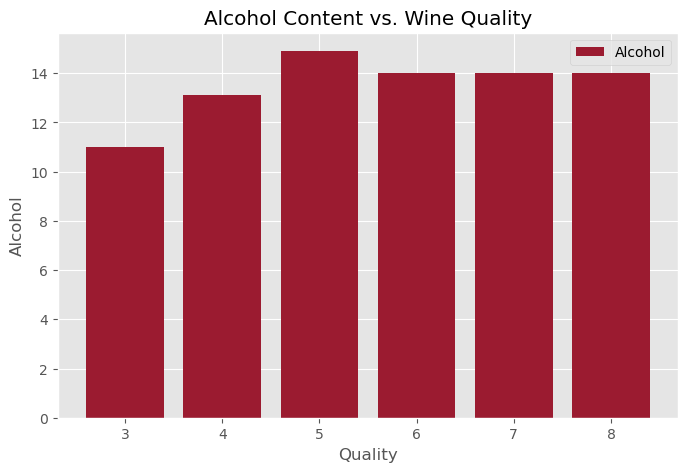

In [22]:
# Alcohol vs. quality
plt.figure(figsize=(8, 5))
plt.bar(df['quality'], df['alcohol'], color='#9b1b30', label='Alcohol')
plt.title('Alcohol Content vs. Wine Quality')
plt.xlabel('Quality')
plt.ylabel('Alcohol')
plt.legend()
plt.show()


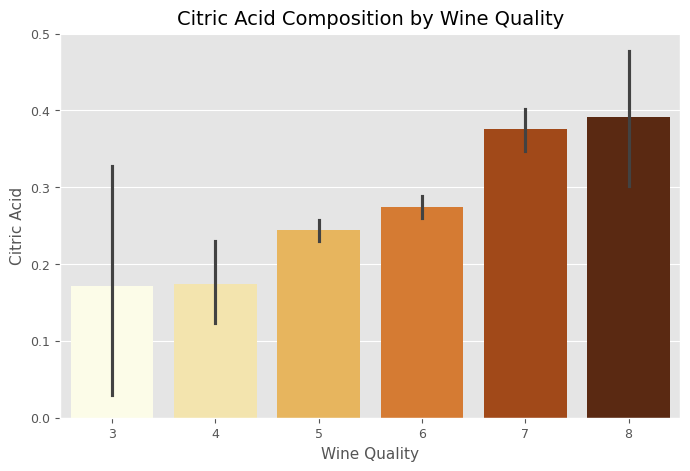

In [24]:
# Citric Acid vs. Quality
plt.figure(figsize=(8, 5))
sns.barplot(x='quality', y='citric acid', data=df, hue='quality', dodge=False, palette='YlOrBr')
plt.title('Citric Acid Composition by Wine Quality', fontsize=14)
plt.xlabel('Wine Quality', fontsize=11)
plt.ylabel('Citric Acid', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend([],[], frameon=False)
plt.show()


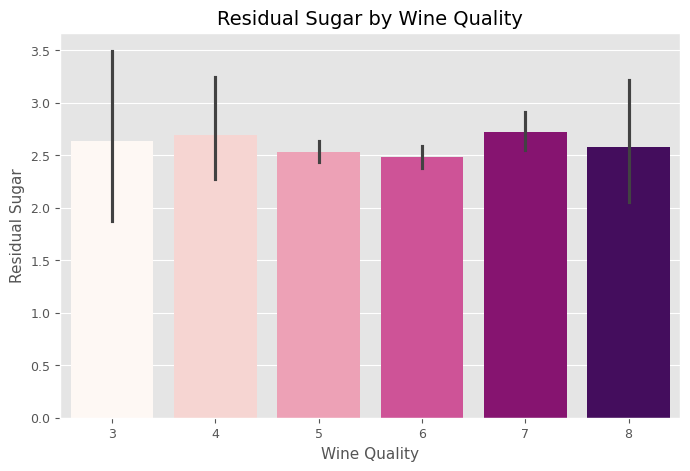

In [26]:
# Residual Sugar vs. Quality
plt.figure(figsize=(8, 5))
sns.barplot(x='quality', y='residual sugar', data=df, hue='quality', dodge=False, palette='RdPu')
plt.title('Residual Sugar by Wine Quality', fontsize=14)
plt.xlabel('Wine Quality', fontsize=11)
plt.ylabel('Residual Sugar', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend([],[], frameon=False)
plt.show()

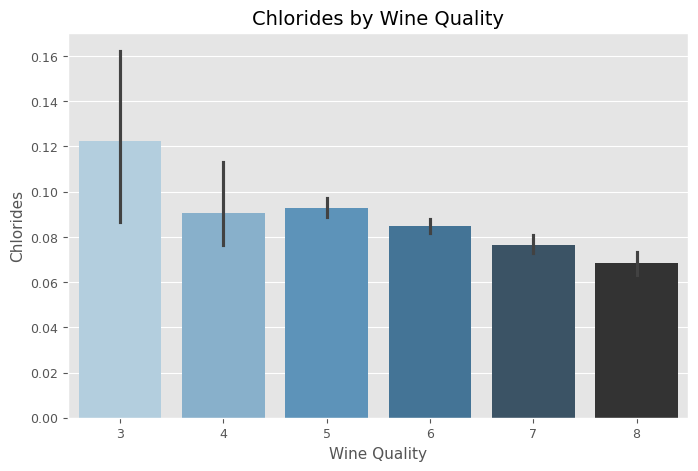

In [28]:
# Chlorides vs. Quality
plt.figure(figsize=(8, 5))
sns.barplot(x='quality', y='chlorides', data=df, hue='quality', dodge=False, palette='Blues_d')
plt.title('Chlorides by Wine Quality', fontsize=14)
plt.xlabel('Wine Quality', fontsize=11)
plt.ylabel('Chlorides', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend([],[], frameon=False)
plt.show()

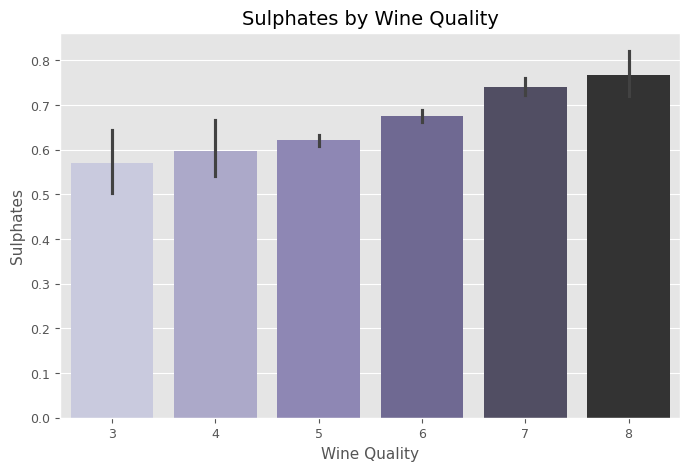

In [30]:
# Sulphates vs. Quality
plt.figure(figsize=(8, 5))
sns.barplot(x='quality', y='sulphates', data=df, hue='quality', dodge=False, palette='Purples_d')
plt.title('Sulphates by Wine Quality', fontsize=14)
plt.xlabel('Wine Quality', fontsize=11)
plt.ylabel('Sulphates', fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.legend([],[], frameon=False)
plt.show()

## **6. Correlation Analysis**

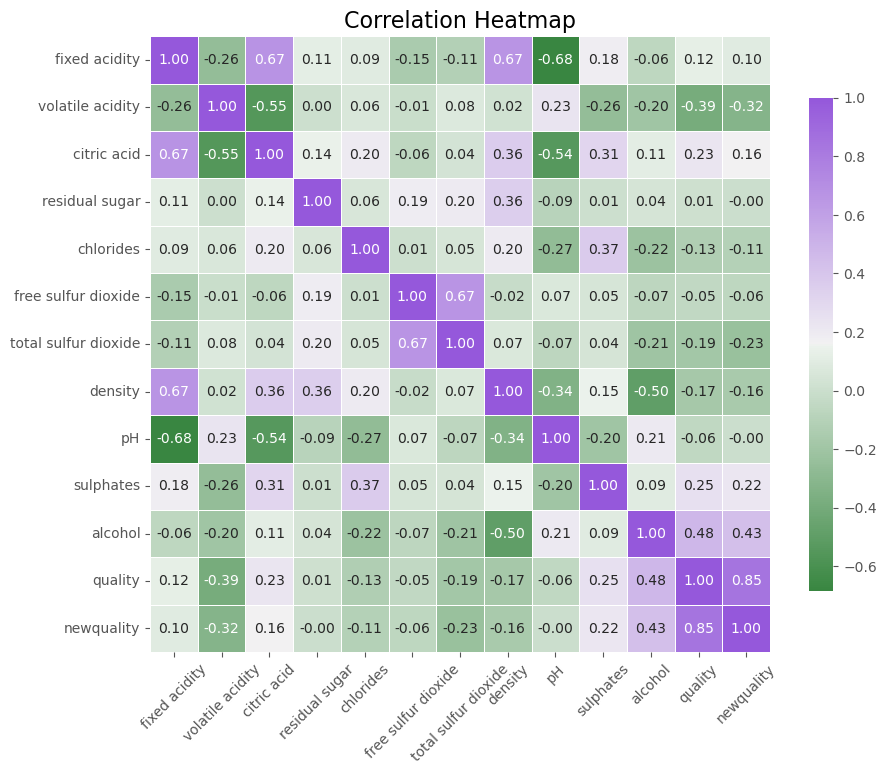

In [32]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
custom_palette = sns.diverging_palette(130, 280, as_cmap=True)
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap=custom_palette, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.show()


## **7. Outlier Detection and Visualisation**

Number of quality outliers detected: 28



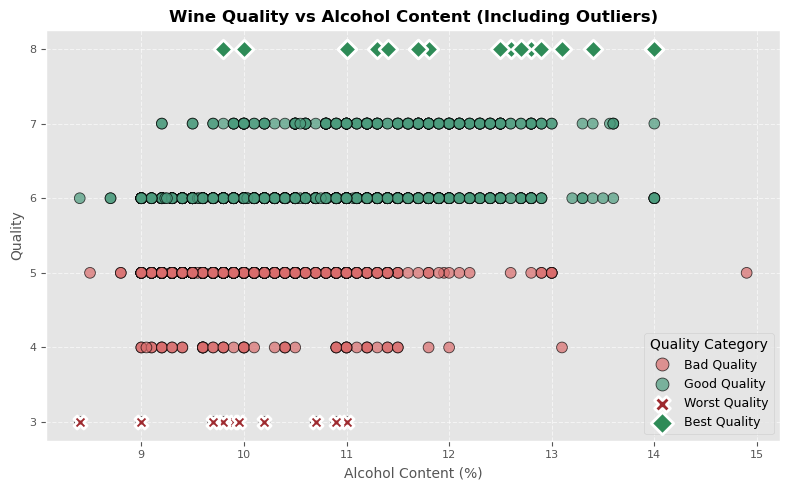

In [40]:
# Function to detect outliers using IQR
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Detect outliers in the 'quality' column
quality_outliers = detect_outliers(df, 'quality')
print(f"Number of quality outliers detected: {len(quality_outliers)}\n")

# Separate outliers by quality category
outliers_bad = quality_outliers[quality_outliers['newquality'] == 1]
outliers_good = quality_outliers[quality_outliers['newquality'] == 2]

# Create a scatter plot for each category and their outliers
plt.figure(figsize=(8, 5))

# Plot for good quality wines (data points)
scatter1 = sns.scatterplot(x='alcohol', y='quality', hue='newquality', data=df, 
                palette={1: '#D96C6C', 2: '#4C9B7D'}, s=60, edgecolor='black', alpha=0.7)

# Outliers for bad quality wines
scatter2 = sns.scatterplot(x='alcohol', y='quality', data=outliers_bad, color='#9E2A2F', s=90, 
                           label='Worst Quality', marker='X', linewidth=2)

# Outliers for good quality wines
scatter3 = sns.scatterplot(x='alcohol', y='quality', data=outliers_good, color='#2E8B57', s=90, 
                           label='Best Quality', marker='D', linewidth=2)

# Title, labels, and customization
plt.title('Wine Quality vs Alcohol Content (Including Outliers)', fontsize=12, fontweight='bold')
plt.xlabel('Alcohol Content (%)', fontsize=10)
plt.ylabel('Quality', fontsize=10)

# Customizing legend and manually setting labels
handles, labels = plt.gca().get_legend_handles_labels()

# Updating legend manually to map 1 and 2 to 'Bad Quality' and 'Good Quality'
new_labels = ['Bad Quality', 'Good Quality', 'Worst Quality', 'Best Quality']

# Add custom legend with updated labels
plt.legend(handles=handles, labels=new_labels, title='Quality Category', title_fontsize=10, fontsize=9, loc='best', markerscale=1.2)

plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

## **8. Feature Selection and Target Variable Preparation**

In [42]:
# Prepare features and target variable
X = df.drop(['quality', 'newquality'], axis=1)
y = df['newquality']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

## **9. Model Training and Evaluation Before Hyperparameter Tuning**

In [44]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Evaluate models before tuning
results_before_tuning = []

for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results_before_tuning.append({
        'Model': name,
        'Accuracy': accuracy,
        'Classification Report': report,
        'Confusion Matrix': cm
    })
    
    print(f"\n{name} (Before Tuning):")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)


Logistic Regression (Before Tuning):
Accuracy: 0.7438
Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.78      0.73       141
           2       0.81      0.72      0.76       179

    accuracy                           0.74       320
   macro avg       0.74      0.75      0.74       320
weighted avg       0.75      0.74      0.74       320

Confusion Matrix:
[[110  31]
 [ 51 128]]

Decision Tree (Before Tuning):
Accuracy: 0.7250
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.73      0.70       141
           2       0.77      0.72      0.75       179

    accuracy                           0.72       320
   macro avg       0.72      0.73      0.72       320
weighted avg       0.73      0.72      0.73       320

Confusion Matrix:
[[103  38]
 [ 50 129]]

Random Forest (Before Tuning):
Accuracy: 0.8000
Classification Report:
              precision    recall  f1-scor

## **10. Hyperparameter Tuning with Randomised Search**

In [47]:

# Define parameter grids for hyperparameter tuning
param_grid = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20, 25, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': ['balanced', None],
        'criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [None, 5, 10, 15, 20],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True, False],
        'class_weight': ['balanced', None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 4],
        'min_samples_split': [2, 5]
    }
}

# Perform randomized search for each model
best_models = {}

def perform_randomized_search(model_name):
    randomized_search = RandomizedSearchCV(
        estimator=models[model_name], 
        param_distributions=param_grid[model_name], 
        n_iter=min(50, len(ParameterGrid(param_grid[model_name]))),
        cv=5,  # Cross-validation folds
        scoring=make_scorer(accuracy_score), 
        n_jobs=-1,  # Use all processors
        random_state=42  # For reproducibility
    )
    randomized_search.fit(X_train_scaled, y_train_resampled)
    return randomized_search

# Apply randomized search for each model
for model_name in models.keys():
    print(f"Performing randomized search for {model_name}...")
    randomized_search_result = perform_randomized_search(model_name)
    best_models[model_name] = randomized_search_result.best_estimator_
    print(f"Best parameters for {model_name}: {randomized_search_result.best_params_}")
    print(f"Best score for {model_name}: {randomized_search_result.best_score_:.4f}\n")

Performing randomized search for Logistic Regression...
Best parameters for Logistic Regression: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}
Best score for Logistic Regression: 0.7419

Performing randomized search for Decision Tree...
Best parameters for Decision Tree: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'criterion': 'entropy', 'class_weight': 'balanced'}
Best score for Decision Tree: 0.7670

Performing randomized search for Random Forest...
Best parameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}
Best score for Random Forest: 0.8240

Performing randomized search for Gradient Boosting...
Best parameters for Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': 4, 'learning_rate': 0.1}
Best score for Gradient Boosting: 0.7981



## **11. Evaluate Models (After Tuning)**

In [49]:
# Evaluate models after tuning
results_after_tuning = []

for model_name in best_models.keys():
    model = best_models[model_name]
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    results_after_tuning.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Best Parameters': model.get_params()
    })

# Create DataFrame to display the results
results_df_after_tuning = pd.DataFrame(results_after_tuning)

# Print results for all models after tuning
print(results_df_after_tuning[['Model', 'Accuracy', 'Best Parameters']])

# Find the best performing model after hyperparameter tuning
best_model_after_tuning = max(results_after_tuning, key=lambda x: x['Accuracy'])
print(f"\nBest overall model after tuning: {best_model_after_tuning['Model']}")
print(f"Best accuracy: {best_model_after_tuning['Accuracy']:.4f}")
print(f"Best parameters: {best_model_after_tuning['Best Parameters']}")

                 Model  Accuracy  \
0  Logistic Regression   0.74375   
1        Decision Tree   0.76875   
2        Random Forest   0.79375   
3    Gradient Boosting   0.81250   

                                     Best Parameters  
0  {'C': 1, 'class_weight': None, 'dual': False, ...  
1  {'ccp_alpha': 0.0, 'class_weight': 'balanced',...  
2  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
3  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  

Best overall model after tuning: Gradient Boosting
Best accuracy: 0.8125
Best parameters: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


## **12. Visualisation of Performances of Models Trained Before and After Hyperparameter Tuning**

In [70]:
# Prepare accuracy data for tabulation
accuracy_comparison = []
for i, model in enumerate(models.keys()):
    before_acc = results_before_tuning[i]['Accuracy']  # Access the 'Accuracy' key from the before-tuning results
    after_acc = results_after_tuning[i]['Accuracy']   # Access the 'Accuracy' key from the after-tuning results
    accuracy_comparison.append([model, before_acc, after_acc])

# Create DataFrame for easier handling and visualisation
df_accuracy_comparison = pd.DataFrame(accuracy_comparison, columns=["Model", "Before Hyperparameter Tuning", "After Hyperparameter Tuning"])

cmap_light = LinearSegmentedColormap.from_list("light_greys", ["white", "lightgrey"])

alt_row_color = "#F2F2F2" 

# Create and display a styled table for model accuracies before and after hyperparameter tuning
styled_table = df_accuracy_comparison.style.apply(
    lambda x: ['background-color: {}'.format(alt_row_color) if i % 2 == 0 else '' for i in range(len(x))], axis=1
).set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', '#D3D3D3'), ('font-size', '14px'), ('border', '1px solid black')]},  
     {'selector': 'tbody td', 'props': [('font-size', '12px'), ('border', '1px solid black')]},
     {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]}, 
     {'selector': 'table', 'props': [('border-collapse', 'collapse')]}, 
     {'selector': 'tr', 'props': [('border', '1px solid black')]},  
    ])

styled_table.set_caption("Accuracy Comparison Before and After Hyperparameter Tuning").hide(axis="index")
styled_table

Model,Before Hyperparameter Tuning,After Hyperparameter Tuning
Logistic Regression,0.743750,0.743750
Decision Tree,0.725000,0.768750
Random Forest,0.800000,0.793750
Gradient Boosting,0.765625,0.812500


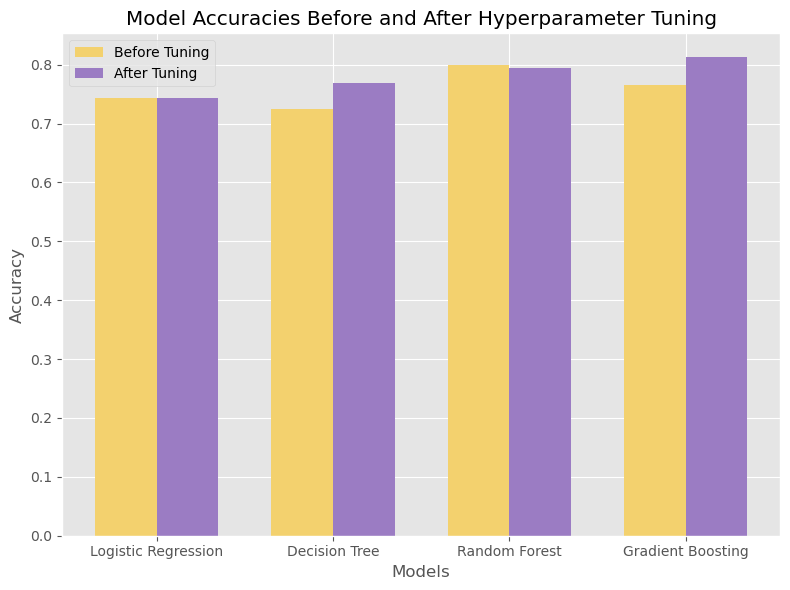

In [74]:
# Accuracies before and after tuning
accuracies_before = [result['Accuracy'] for result in results_before_tuning]
accuracies_after = results_df_after_tuning['Accuracy'].tolist()
model_names = results_df_after_tuning['Model'].tolist()

# Plot comparison
fig, ax = plt.subplots(figsize=(8, 6))
bar_width = 0.35

index_before = np.arange(len(accuracies_before))
index_after = index_before + bar_width

ax.bar(index_before, accuracies_before, bar_width, label='Before Tuning', color='#F3D16E')
ax.bar(index_after, accuracies_after, bar_width, label='After Tuning', color='#9B7CC3')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies Before and After Hyperparameter Tuning')
ax.set_xticks(index_before + bar_width / 2)
ax.set_xticklabels(model_names)
ax.legend()

plt.tight_layout()
plt.show()

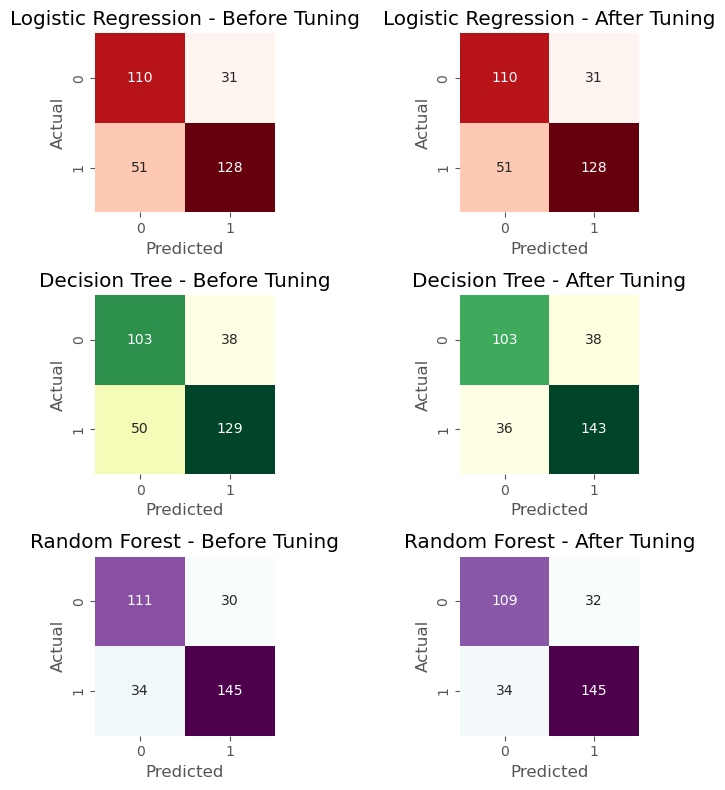

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Create a subplot for confusion matrices
fig, axes = plt.subplots(3, 2, figsize=(8, 8))

# Define models and color maps for each
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
cmap_list = ['Reds', 'YlGn', 'BuPu']

for i, model_name in enumerate(model_names):
    # Confusion Matrix for the model before tuning
    y_pred_before_tuning = models[model_name].predict(X_test_scaled)
    cm_before_tuning = confusion_matrix(y_test, y_pred_before_tuning)
    
    # Confusion Matrix for the best model after tuning
    best_model = best_models[model_name]
    y_pred_after_tuning = best_model.predict(X_test_scaled)
    cm_after_tuning = confusion_matrix(y_test, y_pred_after_tuning)
    
    # Plot before tuning confusion matrix with different color for each model
    ax = axes[i, 0]
    sns.heatmap(cm_before_tuning, annot=True, fmt='d', cmap=cmap_list[i], cbar=False, ax=ax, square=True)
    ax.set_title(f'{model_name} - Before Tuning')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    
    # Plot after tuning confusion matrix with different color for each model
    ax = axes[i, 1]
    sns.heatmap(cm_after_tuning, annot=True, fmt='d', cmap=cmap_list[i], cbar=False, ax=ax, square=True)
    ax.set_title(f'{model_name} - After Tuning')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [84]:
# Prepare classification reports before and after tuning
before_tuning_reports = []
after_tuning_reports = []

for model_name in models.keys():
    # Predict before tuning
    y_pred_before_tuning = models[model_name].predict(X_test_scaled)
    report_before_tuning = classification_report(y_test, y_pred_before_tuning, output_dict=True)
    
    # Predict after tuning
    best_model = best_models[model_name]
    y_pred_after_tuning = best_model.predict(X_test_scaled)
    report_after_tuning = classification_report(y_test, y_pred_after_tuning, output_dict=True)
    
    # Store reports in lists
    before_tuning_reports.append([model_name, report_before_tuning['accuracy'], report_before_tuning['weighted avg']])
    after_tuning_reports.append([model_name, report_after_tuning['accuracy'], report_after_tuning['weighted avg']])

# Combine the reports for tabulation
from tabulate import tabulate

# Prepare data for the table
before_tuning_data = [[report[0], report[1], report[2]['f1-score']] for report in before_tuning_reports]
after_tuning_data = [[report[0], report[1], report[2]['f1-score']] for report in after_tuning_reports]

# Create tables with tabulate
headers = ['Model', 'Accuracy', 'F1-Score (Weighted)']

# Table for before tuning
before_tuning_table = tabulate(before_tuning_data, headers=headers, tablefmt="grid")
print("\nClassification Report Before Hyperparameter Tuning:")
print(before_tuning_table)

# Table for after tuning
after_tuning_table = tabulate(after_tuning_data, headers=headers, tablefmt="grid")
print("\nClassification Report After Hyperparameter Tuning:")
print(after_tuning_table)


Classification Report Before Hyperparameter Tuning:
+---------------------+------------+-----------------------+
| Model               |   Accuracy |   F1-Score (Weighted) |
+=====================+============+=======================+
| Logistic Regression |   0.74375  |              0.744654 |
+---------------------+------------+-----------------------+
| Decision Tree       |   0.725    |              0.725843 |
+---------------------+------------+-----------------------+
| Random Forest       |   0.8      |              0.800269 |
+---------------------+------------+-----------------------+
| Gradient Boosting   |   0.765625 |              0.766446 |
+---------------------+------------+-----------------------+

Classification Report After Hyperparameter Tuning:
+---------------------+------------+-----------------------+
| Model               |   Accuracy |   F1-Score (Weighted) |
+=====================+============+=======================+
| Logistic Regression |    0.74375 |     

## **13. Performance of the Best Model**


Accuracy for the Best Model After Tuning (Gradient Boosting): 0.8125 


Classification Report for the Best Model (Gradient Boosting):
              precision    recall  f1-score   support

           1       0.78      0.79      0.79       141
           2       0.84      0.83      0.83       179

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320
 



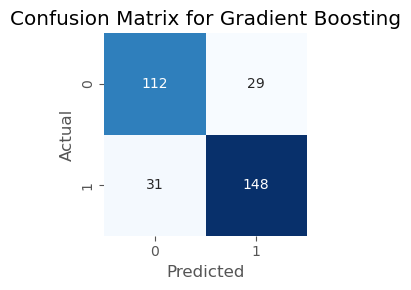

In [88]:
# Find the best model (with highest accuracy)
best_model_name_after_tuning = max(results_after_tuning, key=lambda x: x['Accuracy'])['Model']
best_model = best_models[best_model_name_after_tuning]

# Predictions for the best model
y_pred_best_after_tuning = best_model.predict(X_test_scaled)

# Calculate accuracy for the best model
accuracy_best_after_tuning = accuracy_score(y_test, y_pred_best_after_tuning)

# Print accuracy and classification report for the best model
print(f"\nAccuracy for the Best Model After Tuning ({best_model_name_after_tuning}): {accuracy_best_after_tuning:.4f}", "\n")
print(f"\nClassification Report for the Best Model ({best_model_name_after_tuning}):")
print(classification_report(y_test, y_pred_best_after_tuning), "\n")

# Confusion Matrix for the Best Model
cm_best_after_tuning = confusion_matrix(y_test, y_pred_best_after_tuning)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm_best_after_tuning, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.title(f'Confusion Matrix for {best_model_name_after_tuning}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
